# SERIES TEMPORALES : Dataset passengers 1949-1961

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
passengers=pd.read_csv('AirPassengers.csv', index_col='Month',parse_dates=['Month'])
passengers.rename({'#Passengers':'Passengers'},inplace=True,axis=1)
passengers=passengers.to_period('M')
passengers.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [3]:
passengers.tail()

,Passengers
Month,
1960-08,606
1960-09,508
1960-10,461
1960-11,390
1960-12,432


In [4]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 144 entries, 1949-01 to 1960-12
Freq: M
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [5]:
plt.rcParams['figure.figsize']=18,8

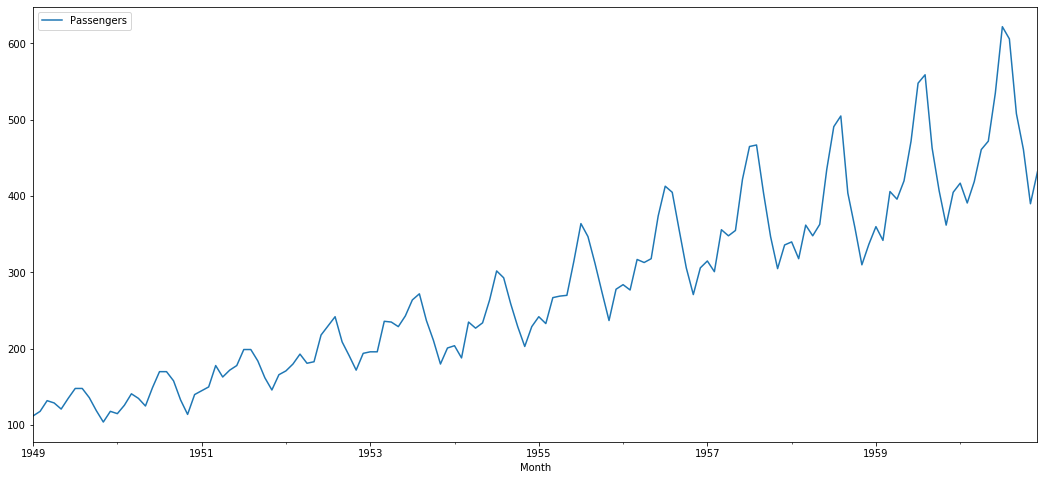

In [6]:
passengers.plot();

- Autocorrelación

In [7]:
for i in 12,24,36:
    print(passengers['Passengers'].corr(passengers['Passengers'].shift(i)))

0.9905273692085445
0.9832540581084244
0.9772832036352764


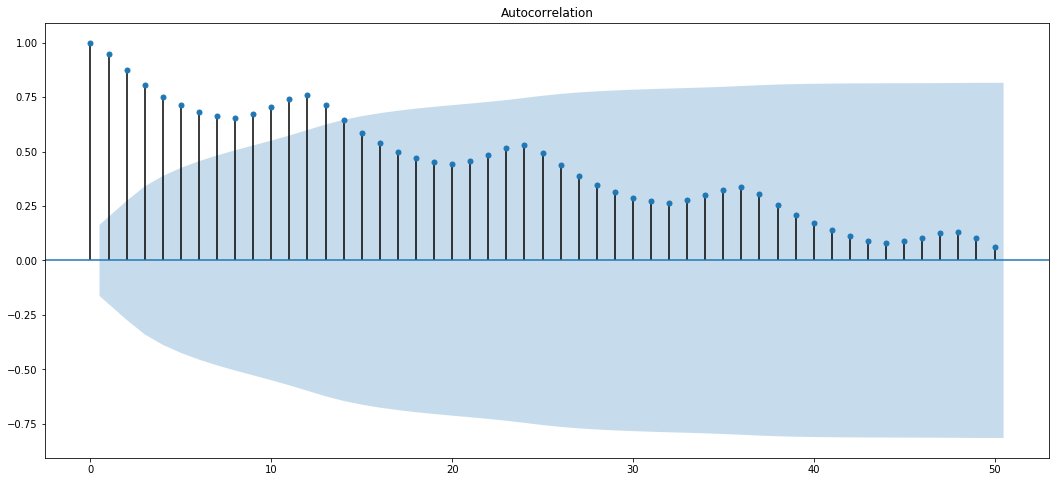

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(passengers,lags=50);

In [9]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

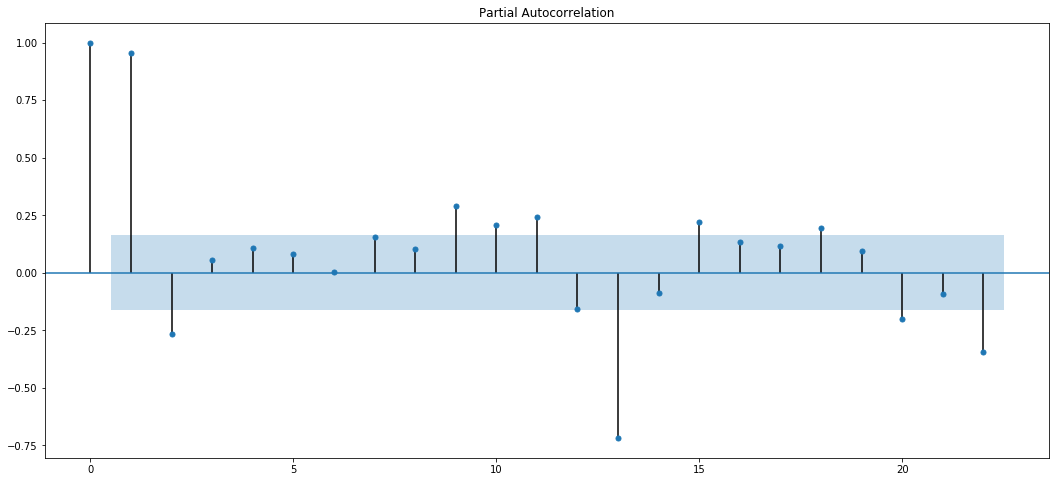

In [10]:
plot_pacf(passengers);

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


In [12]:
adfuller(passengers)





(0.8153688792060456,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

No se puede rechazar la Ho del test Adfuller, por lo que no podemos considerar la serie como estacionaria

- Aplicamos la transformación DIFF

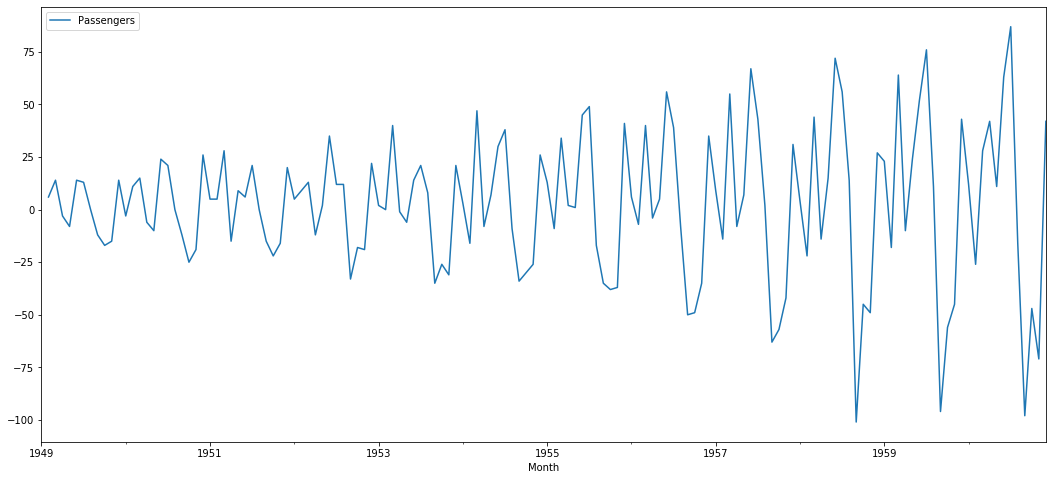

In [13]:
passengers_diff=passengers-passengers.shift(1)
passengers_diff=passengers.diff(1) 
passengers_diff.plot();



In [14]:
passengers_diff=passengers_diff.dropna()

In [15]:
adfuller(passengers_diff)



(-2.8292668241699817,
 0.05421329028382789,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854084)

Con esta transformación, p-valor es del 5,4%, podríamos rechazar la HO de Adfuller y 
suponer que la hemos transformado en una serie estacionaria, pero vamos a aplicar otro cambio para asegurarnos

- Aplicamos la transformación Porcentaje de cambio

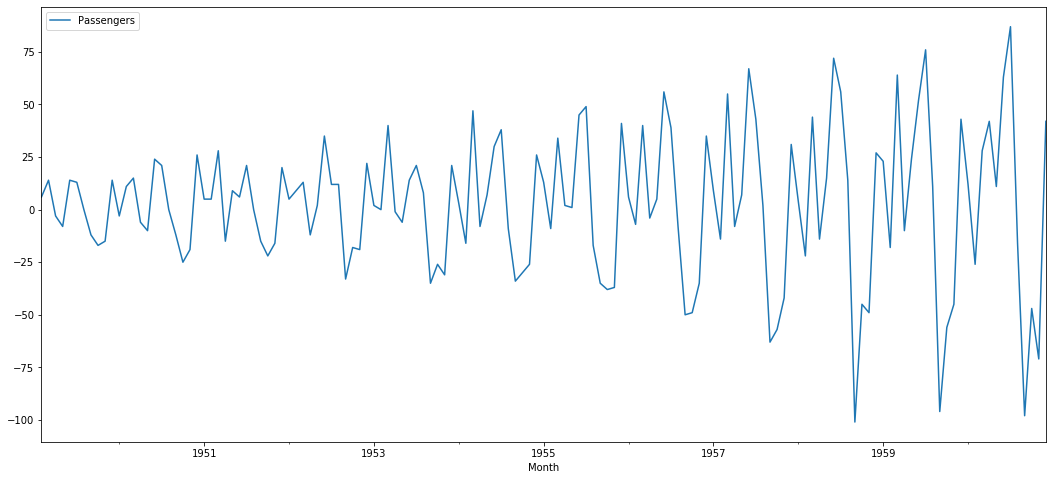

In [16]:
passengers_pct = passengers.pct_change().dropna()  
passengers_diff.plot();

In [17]:
adfuller(passengers_pct)

(-2.926108907545417,
 0.04239503972523596,
 14,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 -425.9255544019345)

Nos muestra que con esta transformación también podemos rechazar la HO de Adfuller, por lo que podemos
suponer también que la hemos transformado en una serie estacionaria

### Voy a calcular manualmente el mejor modelo SARIMA, con un bucle for para encontrar la combinación que minimiza el valor de AIC

In [18]:
best_aic = 999999
for p in range(4):
    for q in range(4):
        for d in range(2):
            try:
                model = SARIMAX(passengers, order = (p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    print(p, d, q, model.aic, model.bic)
            except:
                pass


0 0 0 2057.8473380286773 2060.817151328253
0 1 0 1413.9091174789412 1416.8719621092011


/home/dsc/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0 1 1 1397.257574949218 1403.183264209738
0 1 2 1397.0934620892615 1405.9819959800411
0 1 3 1394.9091477944276 1406.7605263154671


/home/dsc/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


1 1 1 1394.6825053252105 1403.5710392159901
1 1 2 1385.4975450289623 1397.348923550002
2 1 1 1378.3383195987653 1390.189698119805


/home/dsc/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 2 1353.3466409761022 1368.1608641274017


/home/dsc/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 1 3 1345.9274125653878 1366.6673249772073


/home/dsc/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


- Aplico el modelo SARIMA utilizando como rango la mejor combinación obtenida, con una periodicidad anual

In [24]:
model = SARIMAX(passengers.to_timestamp(), order = (3,1,3), seasonal_order = (3,1,3,12)).fit()
model.summary()

/home/dsc/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/dsc/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/dsc/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -490.425
Date:                            Wed, 18 Mar 2020   AIC                           1006.850
Time:                                    18:15:28   BIC                           1044.228
Sample:                                01-01-1949   HQIC                          1022.038
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2807      0.099     -2.832      0.005      -0.475      -0.086
ar.L2         -0.1529      0.109     -1.408      0.159      -0.366       0.060
ar.L3          0.7404      0.108      6.872      0.000       0.529       0.952
ma.L1         -0.0790      0.082     -0.962      0.336      -0.240       0.082
ma.L2          0.0839      0.076      1.108      0.268      -0.065       0.232
ma.L3         -0.9223      0.105     -8.779      0.000      -1.128      -0.716
ar.S.L12       0.2586      1.094      0.236      0.813      -1.885       2.403
ar.S.L24       0.9293      0.953      0.976      0.329      -0.938       2.796
ar.S.L36      -0.2919      0.526     -0.555      0.579      -1.322       0.738
ma.S.L12      -0.7073      1.558     -0.454      0.650      -3.760       2.346
ma.S.L24      -0.7816      1.900     -0.411      0.681      -4.505       2.941
ma.S.L36       0.7983      1.007      0.793      0.428      -1.175       2.772
sigma2        84.4327     36.921      2.287      0.022      12.069     156.796
===================================================================================
Ljung-Box (Q):                       35.27   Jarque-Bera (JB):                 8.93
Prob(Q):                              0.68   Prob(JB):                         0.01
Heteroskedasticity (H):               2.23   Skew:                             0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Ahora entreno el modelo SARIMA utilizando la librería pmdarima para que me detecte de forma automática los órdenes que mejor modelos nos proporcionan

In [23]:
import pmdarima as pm
model2 = pm.auto_arima(
    passengers_diff,
    m = 12,
    suppress_warnings=True)
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -499.077
Date:                            Wed, 18 Mar 2020   AIC                           1014.155
Time:                                    18:05:05   BIC                           1037.156
Sample:                                         0   HQIC                          1023.501
                                            - 143                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.014      0.019      0.985      -0.027       0.027
ar.L1          0.5535      0.097      5.725      0.000       0.364       0.743
ar.L2          0.2453      0.091      2.683      0.007       0.066       0.424
ma.L1         -0.9815      0.048    -20.388      0.000      -1.076      -0.887
ar.S.L12       0.6936      0.294      2.359      0.018       0.117       1.270
ar.S.L24       0.3005      0.123      2.445      0.014       0.060       0.541
ma.S.L12      -0.9620      1.030     -0.934      0.350      -2.981       1.057
sigma2       108.6929     73.095      1.487      0.137     -34.571     251.957
===================================================================================
Ljung-Box (Q):                       53.30   Jarque-Bera (JB):                15.34
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               2.79   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
print('Valores AIC y BIC del primer modelo SARIMA entrenado:',model.aic,model.bic)
print('Valores AIC y BIC del segundo modelo SARIMA entrenado:',model2.aic(),model2.bic())

Valores AIC y BIC del primer modelo SARIMA entrenado: 1006.850056844865 1044.2276220464798
Valores AIC y BIC del segundo modelo SARIMA entrenado: 1014.1546335889034 1037.1562121745126


Vemos que ambos modelos tienen resultados muy similares, tanto el entrenado sacando el orden manualmente, como el entrenado a través de la librería pmdarima

- Diagnóstico del modelo

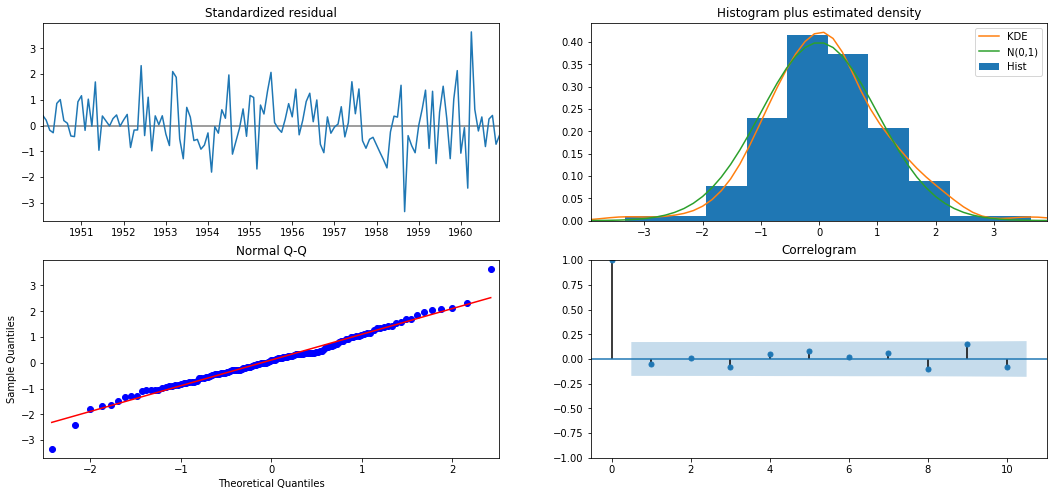

In [31]:
model.plot_diagnostics();

- Descomposición de la serie estacional

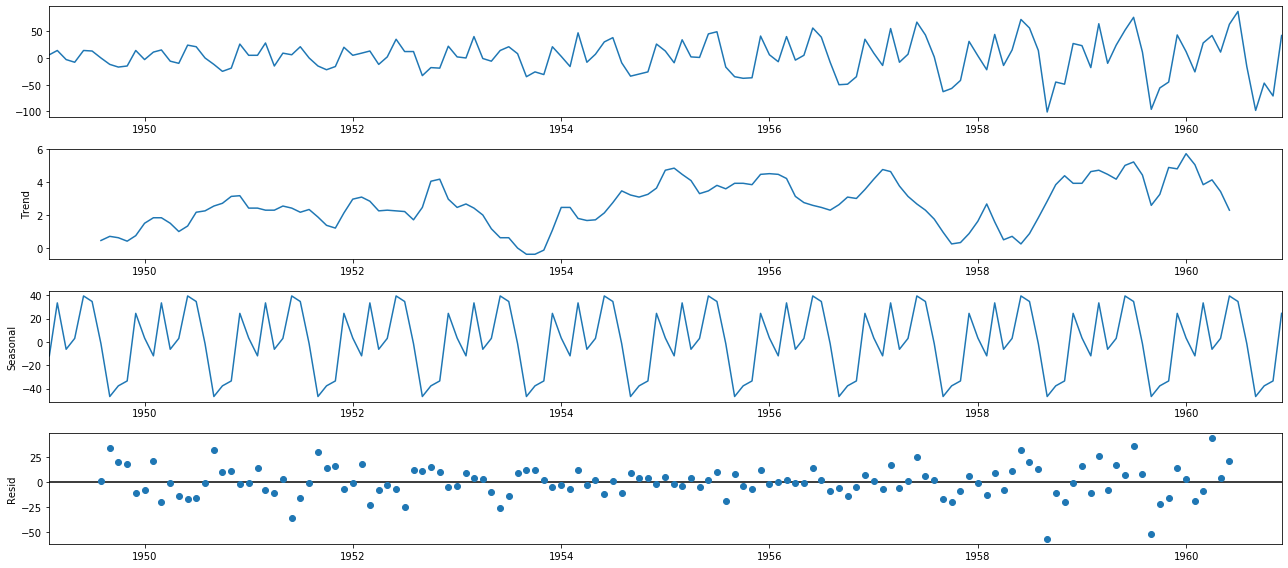

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(x = passengers_diff.dropna().to_timestamp())

decomposition.plot();

### PREDICCIÓN A 2 AÑOS

In [34]:
prediction = model.get_forecast(steps = 24)
prediction


In [35]:
lower = prediction.conf_int()["lower Passengers"]
upper = prediction.conf_int()["upper Passengers"]
prediction.conf_int().head()  

,lower Passengers,upper Passengers
1961-01-01,438.527146,475.408104
1961-02-01,395.092425,438.846101
1961-03-01,444.772859,494.991323
1961-04-01,469.809939,523.788676
1961-05-01,474.533088,529.651379


- Predicciones para los 24 meses siguientes a los datos

In [49]:
prediction.predicted_mean

1961-01-01    456.967625
1961-02-01    416.969263
1961-03-01    469.882091
1961-04-01    496.799307
1961-05-01    502.092234
1961-06-01    581.574996
1961-07-01    673.022560
1961-08-01    657.146790
1961-09-01    555.727253
1961-10-01    500.657617
1961-11-01    424.490481
1961-12-01    474.694811
1962-01-01    497.492243
1962-02-01    451.118134
1962-03-01    508.941353
1962-04-01    533.741670
1962-05-01    539.193057
1962-06-01    631.940490
1962-07-01    727.271548
1962-08-01    712.266377
1962-09-01    601.895304
1962-10-01    540.690874
1962-11-01    459.669105
1962-12-01    515.017759
Freq: MS, dtype: float64

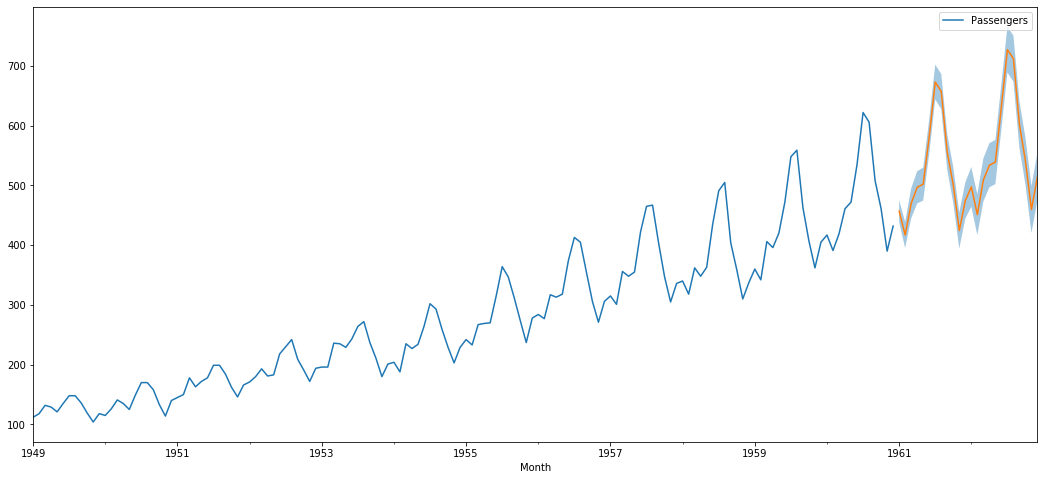

In [44]:
passengers.plot()
prediction.predicted_mean.plot()
plt.fill_between(lower.index, lower, upper, alpha = 0.4)
plt.show()

- Compruebo cómo se ha adaptado el modelo a los datos reales

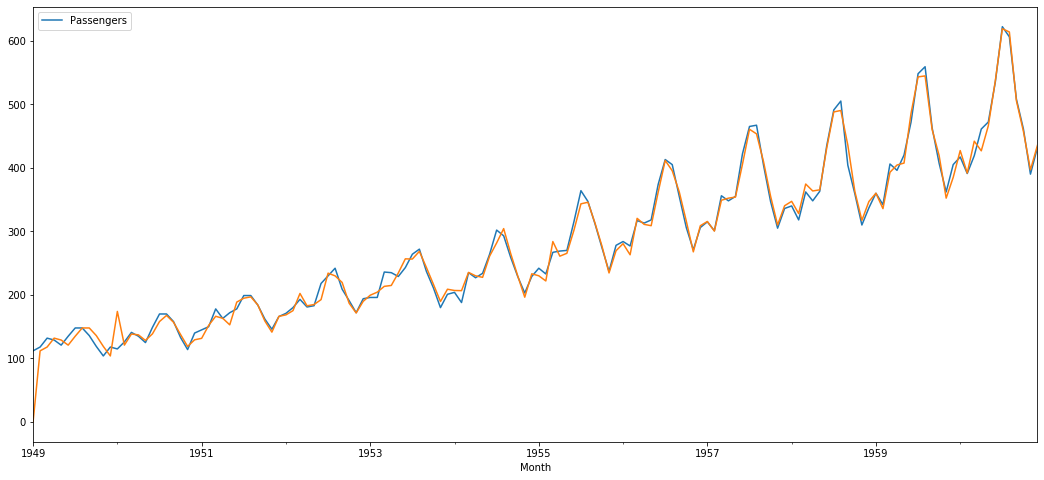

In [47]:
fig, ax = plt.subplots()
passengers.plot(ax = ax)
model.fittedvalues.plot(ax = ax)
plt.show();